# Customer Churn Prediction: EDA, Preprocessing, Model Comparison, and Feature Engineering

## Project Overview and Problem Statement

This project focuses on predicting customer churn in the telecommunications industry. Churn refers to customers who leave a service provider, and predicting churn is crucial for improving customer retention and business profitability.

The problem is formulated as a supervised learning task, where the goal is to predict a binary outcome, whether a customer will churn (Yes) or not (No).

Since the target variable is categorical with two possible outcomes, this is a binary classification problem. Various classification algorithms will be explored and compared to build a robust predictive model.
Through this project, I aim to understand which features most strongly influence customer churn, evaluate model performance using appropriate metrics (e.g., ROC-AUC, F1-score), and identify the best-performing supervised learning approach for this classification task.

## Data Source

The dataset used in this project is the Telco Customer Churn dataset, which contains customer information from a telecommunications company, including demographic details, account data, services subscribed to, and whether the customer has churned. The target variable is Churn, indicating if the customer left (Yes) or stayed (No).

The dataset is publicly available on Kaggle: [Telco Customer Churn – Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

It includes 7043 samples and 20 features, with a mix of numerical, binary, and categorical variables.

There is also a more extensive version of this dataset published by IBM, which includes more features and additional records:
[IBM Telco Customer Churn (extended version)](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

However, for the scope of this project, we use the Kaggle version due to its simpler structure, which is more manageable for demonstrating supervised learning techniques within the project constraints.

### Dataset Explanation

The dataset consists of 7043 rows (customers) and 21 columns (20 features + 1 target variable). It is in tabular format, with each row representing a customer and each column representing a demographic, service-related, or account-related attribute.

Among the features:

- 13 are categorical (e.g., gender, InternetService, Contract)
- 3 are numerical (tenure, MonthlyCharges, TotalCharges)
- 5 are binary (SeniorCitizen, Partner, Dependents, etc.)

The dataset is self-contained (not multi-table) and does not require external data merging. It is relatively small in size (under 1 MB), making it manageable for exploratory data analysis and model experimentation.

Here's the full list of columns in the dataset

* ``customerID``: Unique ID for each customer
* ``gender``: Gender of the customer (`Male` or `Female`)
* ``SeniorCitizen``: Indicates if the customer is a senior (`1` = Yes, `0` = No)
* ``Partner``: Whether the customer has a partner (`Yes` or `No`)
* ``Dependents``: Whether the customer has dependents (`Yes` or `No`)
* ``tenure``: Number of months the customer has been with the company
* ``PhoneService``: Whether the customer has phone service (`Yes` or `No`)
* ``MultipleLines``: Has multiple phone lines (`Yes`, `No`, or `No phone service`)
* ``InternetService``: Type of internet service (`DSL`, `Fiber optic`, or `No`)
* ``OnlineSecurity``: Whether online security is included (`Yes`, `No`, or `No internet service`)
* ``OnlineBackup``: Whether online backup is included (`Yes`, `No`, or `No internet service`)
* ``DeviceProtection``: Whether device protection is included (`Yes`, `No`, or `No internet service`)
* ``TechSupport``: Whether tech support is included (`Yes`, `No`, or `No internet service`)
* ``StreamingTV``: Access to streaming TV (`Yes`, `No`, or `No internet service`)
* ``StreamingMovies``: Access to streaming movies (`Yes`, `No`, or `No internet service`)
* ``Contract``: Type of contract (`Month-to-month`, `One year`, `Two year`)
* ``PaperlessBilling``: Whether billing is paperless (`Yes` or `No`)
* ``PaymentMethod``: Method of payment (`Electronic check`, `Mailed check`, etc.)
* ``MonthlyCharges``: Monthly amount charged to the customer
* ``TotalCharges``: Total amount charged over the tenure
* ``Churn``: Target variable. Whether the customer churned (`Yes` or `No`)


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import seaborn as sns

In [42]:
# Constants for the EDA and modeling process
TARGET_COLUMN = "Churn"
RANDOM_STATE = 42
K_FOLDS = 5
RESULT_PATH = "./results/"
RESULT_FINE_NAME = "model_comparison_results."
RESULT_FINE_EXT = "csv"
DATASET_PATH = "./data/Telco-Customer-Churn.csv"

## Exploratory Data Analysis (EDA)

### Basic Data Exploration and Preprocessing

In [43]:
df = pd.read_csv(DATASET_PATH, delimiter=',')

In [44]:
print(f'shape: {df.shape}')
print(f'columns: {df.columns.tolist()}')

shape: (7043, 21)
columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [45]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

SeniorCitizen is binary coloumn and it already `int64` type, however, we need to covert columns like gender, Partner, Dependents, etc to `category` type.

In general, we have three categories of columns:
1. Numerical columns
2. Categorical columns
3. Binary columns

However, I also consider separating features based on their domain, such as service, demographic, and payment features. This will help in understanding the data better later on.

One important thing to note is that the `TotalCharges` column is a numerical column, but it has a type of `object` due to some non-numeric values. We need to convert it to a numeric type and handle any errors that arise from non-numeric values.

Before we proceed with the conversion, let's check the unique values in each column to understand the data better.

In [46]:
# unique values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values : {df[col].unique()} unique values')

customerID: 7043 unique values : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] unique values
gender: 2 unique values : ['Female' 'Male'] unique values
SeniorCitizen: 2 unique values : [0 1] unique values
Partner: 2 unique values : ['Yes' 'No'] unique values
Dependents: 2 unique values : ['No' 'Yes'] unique values
tenure: 73 unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] unique values
PhoneService: 2 unique values : ['No' 'Yes'] unique values
MultipleLines: 3 unique values : ['No phone service' 'No' 'Yes'] unique values
InternetService: 3 unique values : ['DSL' 'Fiber optic' 'No'] unique values
OnlineSecurity: 3 unique values : ['No' 'Yes' 'No internet service'] unique values
OnlineBackup: 3 unique values : ['Yes' 'No' 'No internet service'] unique values
Dev

We can see that the `gender`, `Partner`, `Dependents`, `PhoneService`, and `PaperlessBilling` columns have binary values, while the `InternetService`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` columns are categorical with multiple unique values. The `Contract` and `PaymentMethod` columns also have categorical values.

In [47]:
demographic_features = ["gender", "SeniorCitizen", "Partner", "Dependents"]
service_features = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection", "StreamingTV", "StreamingMovies", "TechSupport"]
payment_features = ["Contract", "PaperlessBilling", "PaymentMethod"]

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
categorical_features = list(set(service_features + payment_features) - set(binary_features))
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
features = demographic_features + service_features + payment_features


In [48]:
# handling TotalCharges column
print(f'TotalCharges type before conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

TotalCharges type before conversion: object, total null values: 0


While converting the `TotalCharges` column to numeric, we use `errors='coerce'` to convert any non-numeric values to NaN. This is important because it allows us to handle any invalid entries without causing the entire conversion to fail. After this conversion, we can decide how to handle these NaN values, either by dropping them or filling them with a specific value.
Let's check how many NaN values we have in the `TotalCharges` column and then drop them if necessary.

In [49]:
print(f'TotalCharges type after conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')

TotalCharges type after conversion: float64, total null values: 11


Now the data type of `TotalCharges` is `float64`, but we have 11 rows with NaN values after the conversion. Let's check these rows in the original dataframe.

In [50]:
temp_df = pd.read_csv(DATASET_PATH, delimiter=',')
temp_df.loc[df[df['TotalCharges'].isnull()].index, 'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

It is clear that these rows have no values in the `TotalCharges` column, which is why they were converted to NaN. Since these rows do not provide any useful information for our analysis and the total number of rows is small (11), we can safely drop them from the dataset.

In [51]:
df = df.dropna(subset=['TotalCharges'])
print(f'Total null values: {df["TotalCharges"].isna().sum()}')

Total null values: 0


As we saw in the previous steps, `customerID` is a unique identifier for each customer and does not provide any useful information for our analysis. Therefore, we can drop this column from the dataset.

In [52]:
# drop customerID column
df = df.drop(columns=['customerID'])

In [53]:
# check null and duplicated values in the dataset
print(f'Total null values in the dataset: {df.isna().sum().sum()}')
print(f'Total duplicated rows in the dataset: {df.duplicated().sum()}')

Total null values in the dataset: 0
Total duplicated rows in the dataset: 22


We have 22 duplicated rows in the dataset, however, considering these are belong to different customers, we can keep them as they are. We also have no null values in the dataset, which is great.

### Target Variable Distribution

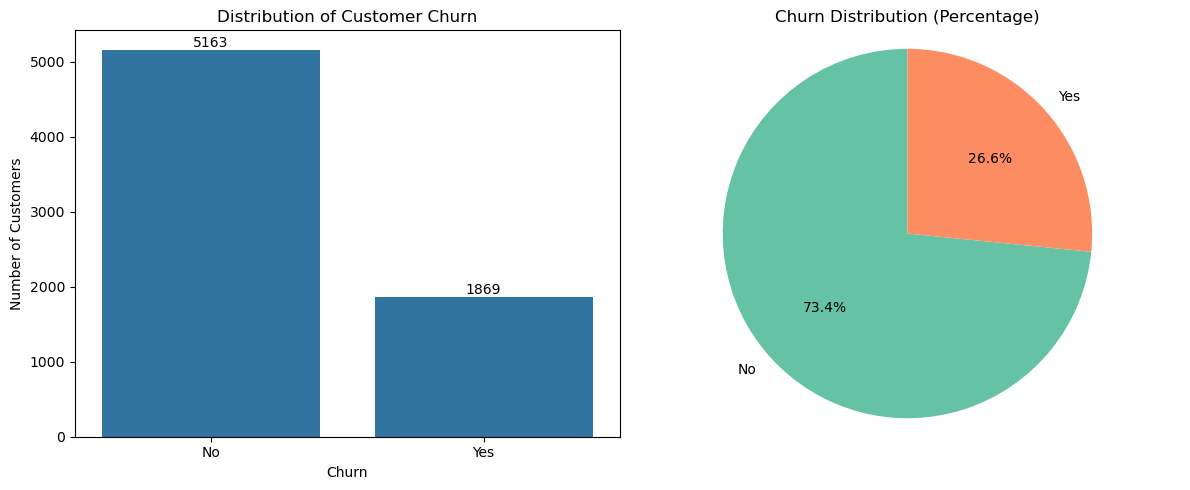

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Countplot
sns.countplot(x="Churn", data=df, ax=axes[0])
axes[0].set_title("Distribution of Customer Churn")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Number of Customers")
axes[0].bar_label(axes[0].containers[0])

# Right: Pie Chart
churn_counts = df['Churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100
axes[1].pie(churn_percent, labels=churn_percent.index, autopct='%1.1f%%',
            startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[1].set_title("Churn Distribution (Percentage)")
axes[1].axis('equal')

plt.tight_layout()
plt.show()


Looking at the distribution of the target variable `Churn`, we can see that the dataset is imbalanced, with a higher number of customers who did not churn compared to those who did. This is a common scenario in churn prediction tasks and will require special attention during model training to ensure that the model does not become biased towards the majority class.

### Numerical Features Analysis

Let's start with the numerical feature analysis. We will check the distribution of each numerical feature and their correlation with the target variable `Churn`. Let's start with a boxplot to visualize the distribution of numerical features.

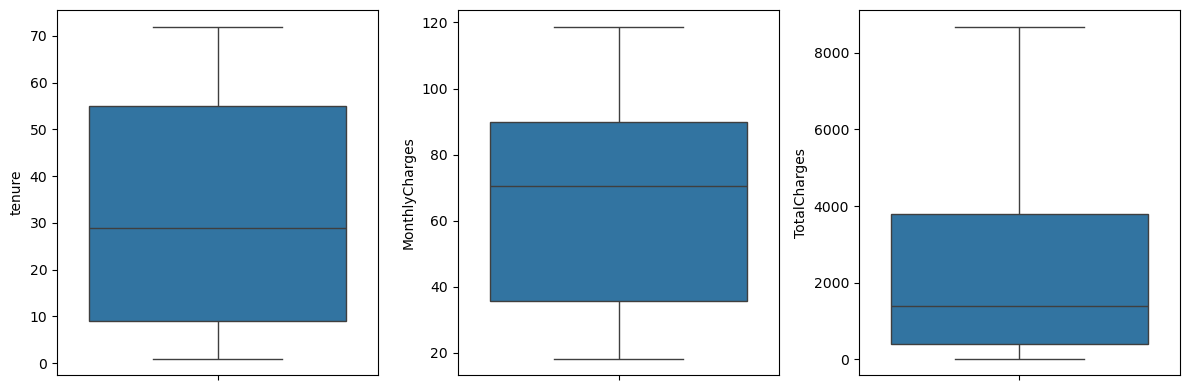

In [55]:
plt.figure(figsize=(12, 4))

for i in range(0, len(numeric_features)):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(data=df, y=numeric_features[i])
    plt.tight_layout()

**Analysis of Numerical Features**

The boxplots for `tenure`, `MonthlyCharges`, and `TotalCharges` provide insight into the distribution and spread of these numerical variables. The `tenure` feature shows a relatively wide distribution, with a median around 29 months and no visible outliers, indicating a stable range of customer contract lengths. Similarly, `MonthlyCharges` is moderately right-skewed, with most customers paying between 35 and 90 per month. There are no extreme values beyond the whiskers, suggesting that premium-tier customers fall within a reasonable range.

The `TotalCharges` feature exhibits a pronounced right skew, which is expected given its dependency on both tenure and monthly charges. Although some customers have paid significantly more over time, these values are within the expected bounds and are not treated as outliers. Overall, the numerical features appear well-behaved and do not require special treatment for outliers at this stage of the analysis.


Now, let's analyze the correlation of these numerical features with the target variable `Churn`. We will use a boxplot to visualize the distribution of each numerical feature based on the `Churn` status.

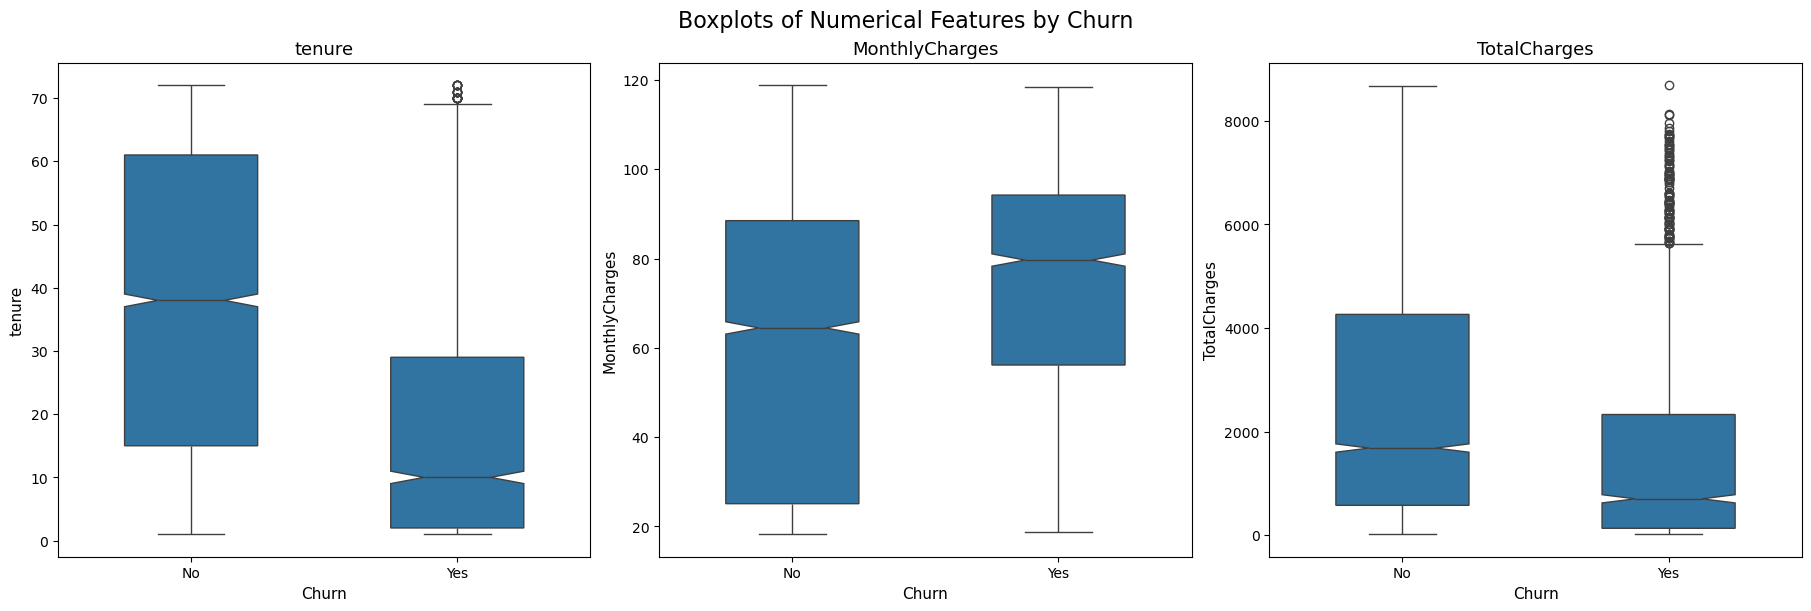

In [56]:
# Set theme


# Create subplots
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6), constrained_layout=True)

# Loop over numeric features
for i, col in enumerate(numeric_features):
    sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], width=0.5, notch=True)
    axes[i].set_title(f"{col}", fontsize=13)
    axes[i].set_xlabel("Churn", fontsize=11)
    axes[i].set_ylabel(col, fontsize=11)
    axes[i].tick_params(labelsize=10)

# Add main title
fig.suptitle("Boxplots of Numerical Features by Churn", fontsize=16)

plt.show()

The boxplots clearly show different patterns in the numerical features based on churn status. Customers who did not churn have a much higher median `tenure` compared to those who churned, meaning loyal customers tend to stay longer. In contrast, customers who churned often have very short tenure, suggesting that many leave early in their contract period.

For `MonthlyCharges`, customers who churn generally pay more on average than those who stay. This could suggest that higher monthly costs may lead to dissatisfaction or affordability issues. The `TotalCharges` feature also shows a strong difference. Since it is the product of tenure and monthly charges, it makes sense that customers who churn have much lower total charges. This supports the idea that they often leave early. Overall, these numerical features provide useful signals for predicting churn.


To better understand the numerical features, Let's also look at the histogram with KDE (Kernel Density Estimate) for each numerical feature. This will help us visualize the distribution of values and identify any skewness or unusual patterns.

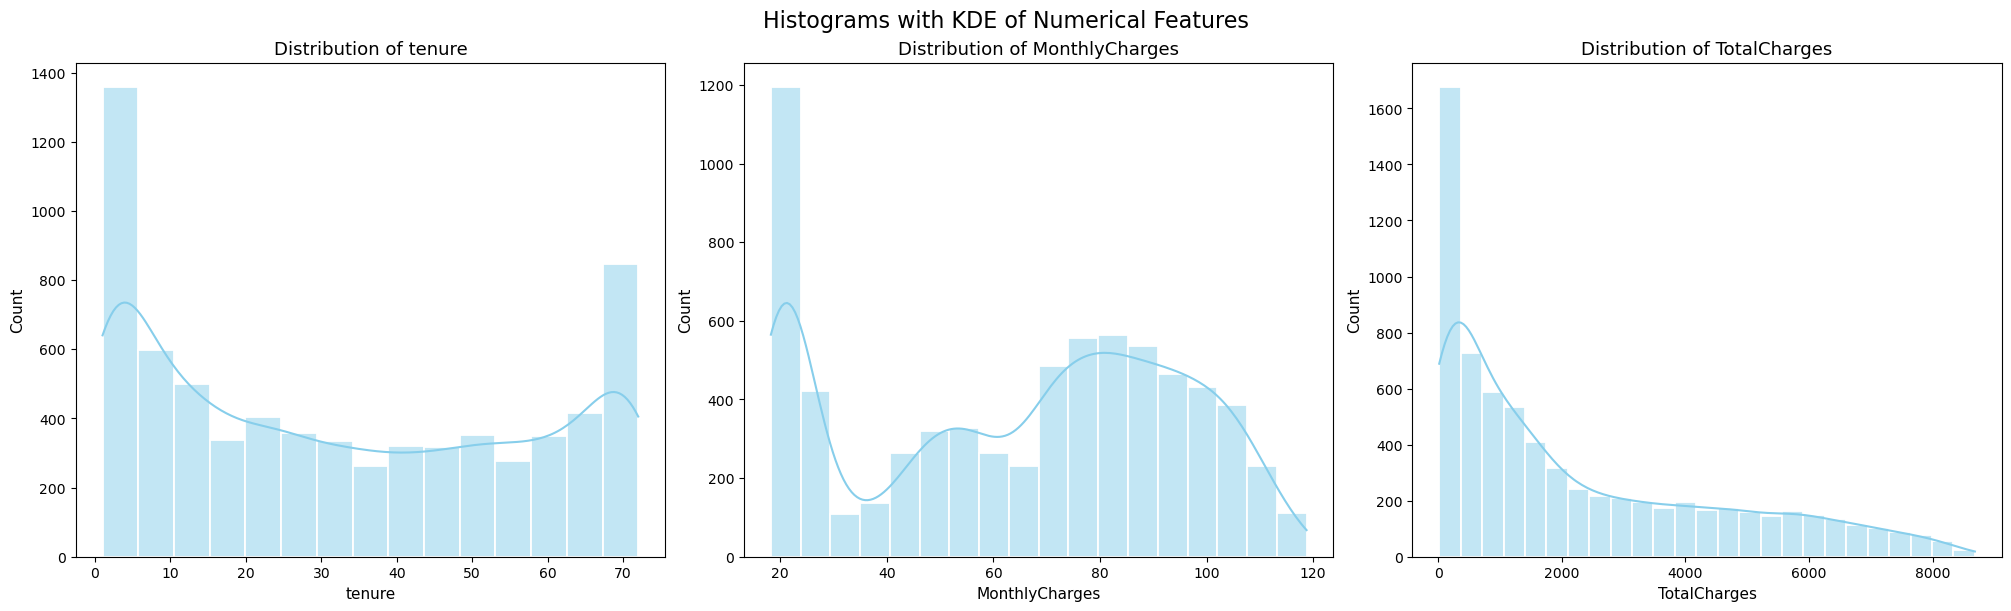

In [57]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 6), constrained_layout=True)

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", edgecolor="white", linewidth=1.3)
    axes[i].set_title(f"Distribution of {col}", fontsize=13)
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel("Count", fontsize=11)
    axes[i].tick_params(labelsize=10)

fig.suptitle("Histograms with KDE of Numerical Features", fontsize=16)
plt.show()

The histograms with KDE curves provide a deeper view of how the numerical features are distributed. The `tenure` variable shows a bimodal pattern, with many customers at the beginning (around 0–10 months) and another peak around 70 months. This suggests that some customers leave very early, while others tend to stay for many years.

The `MonthlyCharges` feature appears roughly right-skewed, with a concentration of customers around 70–90. However, there is also a significant number of customers paying less than 30. The `TotalCharges` variable is strongly right-skewed, which makes sense since it accumulates over time based on both tenure and monthly charges. Many customers have relatively low total charges, likely due to short tenure. These distributions confirm that feature scaling or transformations might be useful before modeling.


Next step, we use `sns.pairplot` to visualize the relationships between numerical features and the target variable `Churn`. This will help us see how these features interact with each other and with churn.

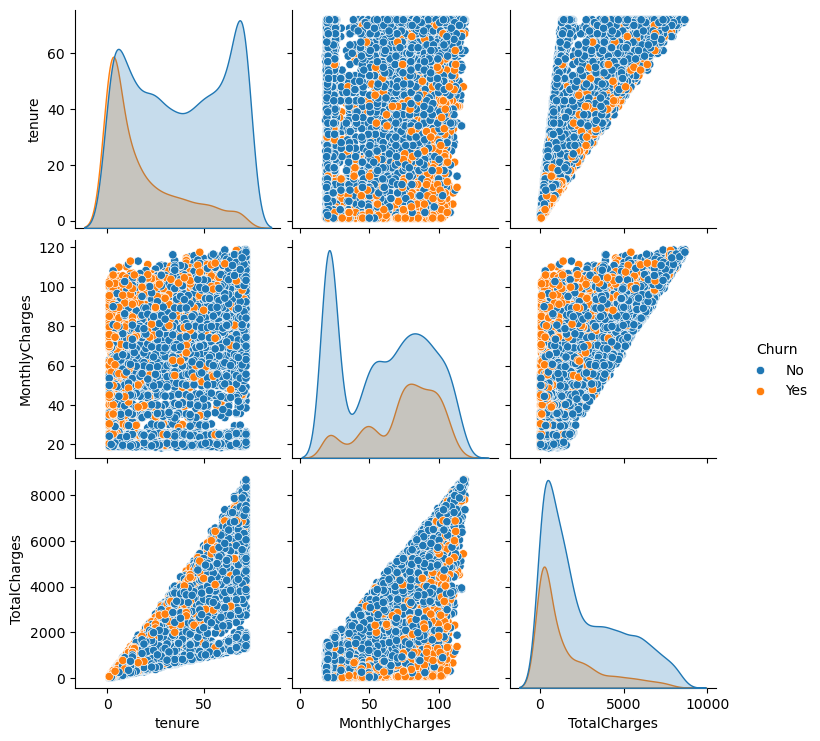

In [58]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')

The pairplot shows the relationships between `tenure`, `MonthlyCharges`, and `TotalCharges`, colored by churn status. We can observe that customers who churned (orange) tend to have lower `tenure` and lower `TotalCharges`, but often have higher `MonthlyCharges`. This supports earlier findings that customers who leave usually do so early and may be paying more per month.

There is also a strong positive linear relationship between `tenure` and `TotalCharges`, which is expected since longer-tenure customers accumulate higher total charges. The density plots along the diagonal show clear separation between churned and non-churned customers, especially in `tenure` and `TotalCharges`. Overall, this plot confirms that these numerical features are useful for distinguishing between churned and retained customers.


Now, let's analyze the correlation matrix for the numerical features, including the target variable `Churn`. This will help us quantify the relationships between these features and identify any strong correlations.

<Axes: >

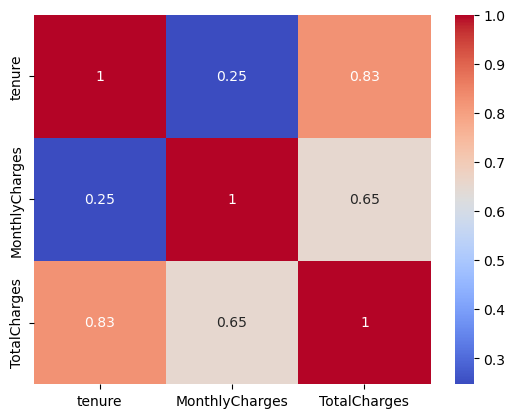

In [59]:
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

This correlation matrix focuses only on continuous numerical features: `tenure`, `MonthlyCharges`, and `TotalCharges`. The strongest correlation is between `tenure` and `TotalCharges` (0.83), which is expected since the total charges accumulate over time. There is also a moderate positive correlation between `MonthlyCharges` and `TotalCharges` (0.65), showing that customers with higher monthly fees tend to have higher total charges.

The correlation between `tenure` and `MonthlyCharges` is relatively weak (0.25), suggesting that the monthly rate does not strongly depend on how long a customer stays. Overall, this heatmap confirms that `TotalCharges` is influenced by both other features, and that `tenure` and `MonthlyCharges` each contribute useful, but different, information to churn prediction.


#### VIF Analysis

To get a better insight into the correlation of features, let's take a look at the VIF (Variance inflaction factor) of the features. VIP helps us to identify multicollinearity among features. A high VIF indicates that a feature is highly correlated with other features, which can lead to issue in model training.

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert target to binary
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Define target and numeric features (exclude TotalSpendEstimate)
TARGET_COLUMN = "Churn"
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']  # No TotalSpendEstimate

# Prepare X matrix
X = df[numeric_features].copy()
X['Intercept'] = 1  # Add intercept for VIF computation

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop intercept from results (optional)
vif_data = vif_data[vif_data['Feature'] != 'Intercept']

print(vif_data)


          Feature       VIF
0          tenure  5.844646
1  MonthlyCharges  3.225293
2    TotalCharges  9.526697


To further investigate multicollinearity, we calculated the Variance Inflation Factor (VIF) for the three numerical features. The results show that `TotalCharges` has a high VIF value of 9.53, indicating strong multicollinearity with other features. This makes sense given that `TotalCharges` is closely related to both `tenure` and `MonthlyCharges`.

In contrast, `tenure` and `MonthlyCharges` have lower VIF values of 5.84 and 3.23, which are within acceptable ranges. These findings suggest that if we use linear models like logistic regression, it may be beneficial to drop `TotalCharges` to avoid instability caused by multicollinearity. However, for tree-based models like Random Forest, all features can be safely included.

#### Summary of Numerical Feature Significance

Based on the exploratory analysis, including boxplots, distribution plots, pairplots, and correlation matrix, we can draw conclusions about the significance of the numerical features in relation to the target variable `Churn`.

The feature `tenure` appears to be the most significant indicator of churn. Customers who churn tend to have much shorter tenure, suggesting they leave early in their customer lifecycle. This is clearly visible in both the boxplots and pairplots, where churned customers are concentrated at low tenure values.

`MonthlyCharges` also shows a moderate association with churn. Customers who churn are more likely to be paying higher monthly fees, which might indicate dissatisfaction or affordability issues. Although the relationship is weaker than with tenure, it still adds meaningful information.

On the other hand, `TotalCharges` is highly correlated with `tenure` (correlation coefficient ≈ 0.83) and is largely derived from it. While it does reflect overall customer spending, it may not add much independent value for churn prediction and could introduce multicollinearity if used alongside `tenure`.

To verify this, we computed the Variance Inflation Factor (VIF) for each feature. The VIF score for `TotalCharges` was 9.53—close to the commonly used threshold of 10—indicating a high degree of multicollinearity. In contrast, `tenure` and `MonthlyCharges` had acceptable VIF values of 5.84 and 3.23, respectively. This supports the conclusion that `tenure` and `MonthlyCharges` should be prioritized, and `TotalCharges` should be excluded from linear models or used cautiously depending on the modeling technique.

In conclusion, `tenure` and `MonthlyCharges` are significant numerical features for predicting churn, while `TotalCharges` shows redundancy and multicollinearity risk that may affect certain models.


### Categorical Features Analysis


For categorical features, we first plot the distribution of each feature based on their values (categories) and then analyze their correlation with the target variable `Churn`. We will use count plots for categorical features and a bar plot for the correlation analysis. Let's start with the count plots for each categorical feature.

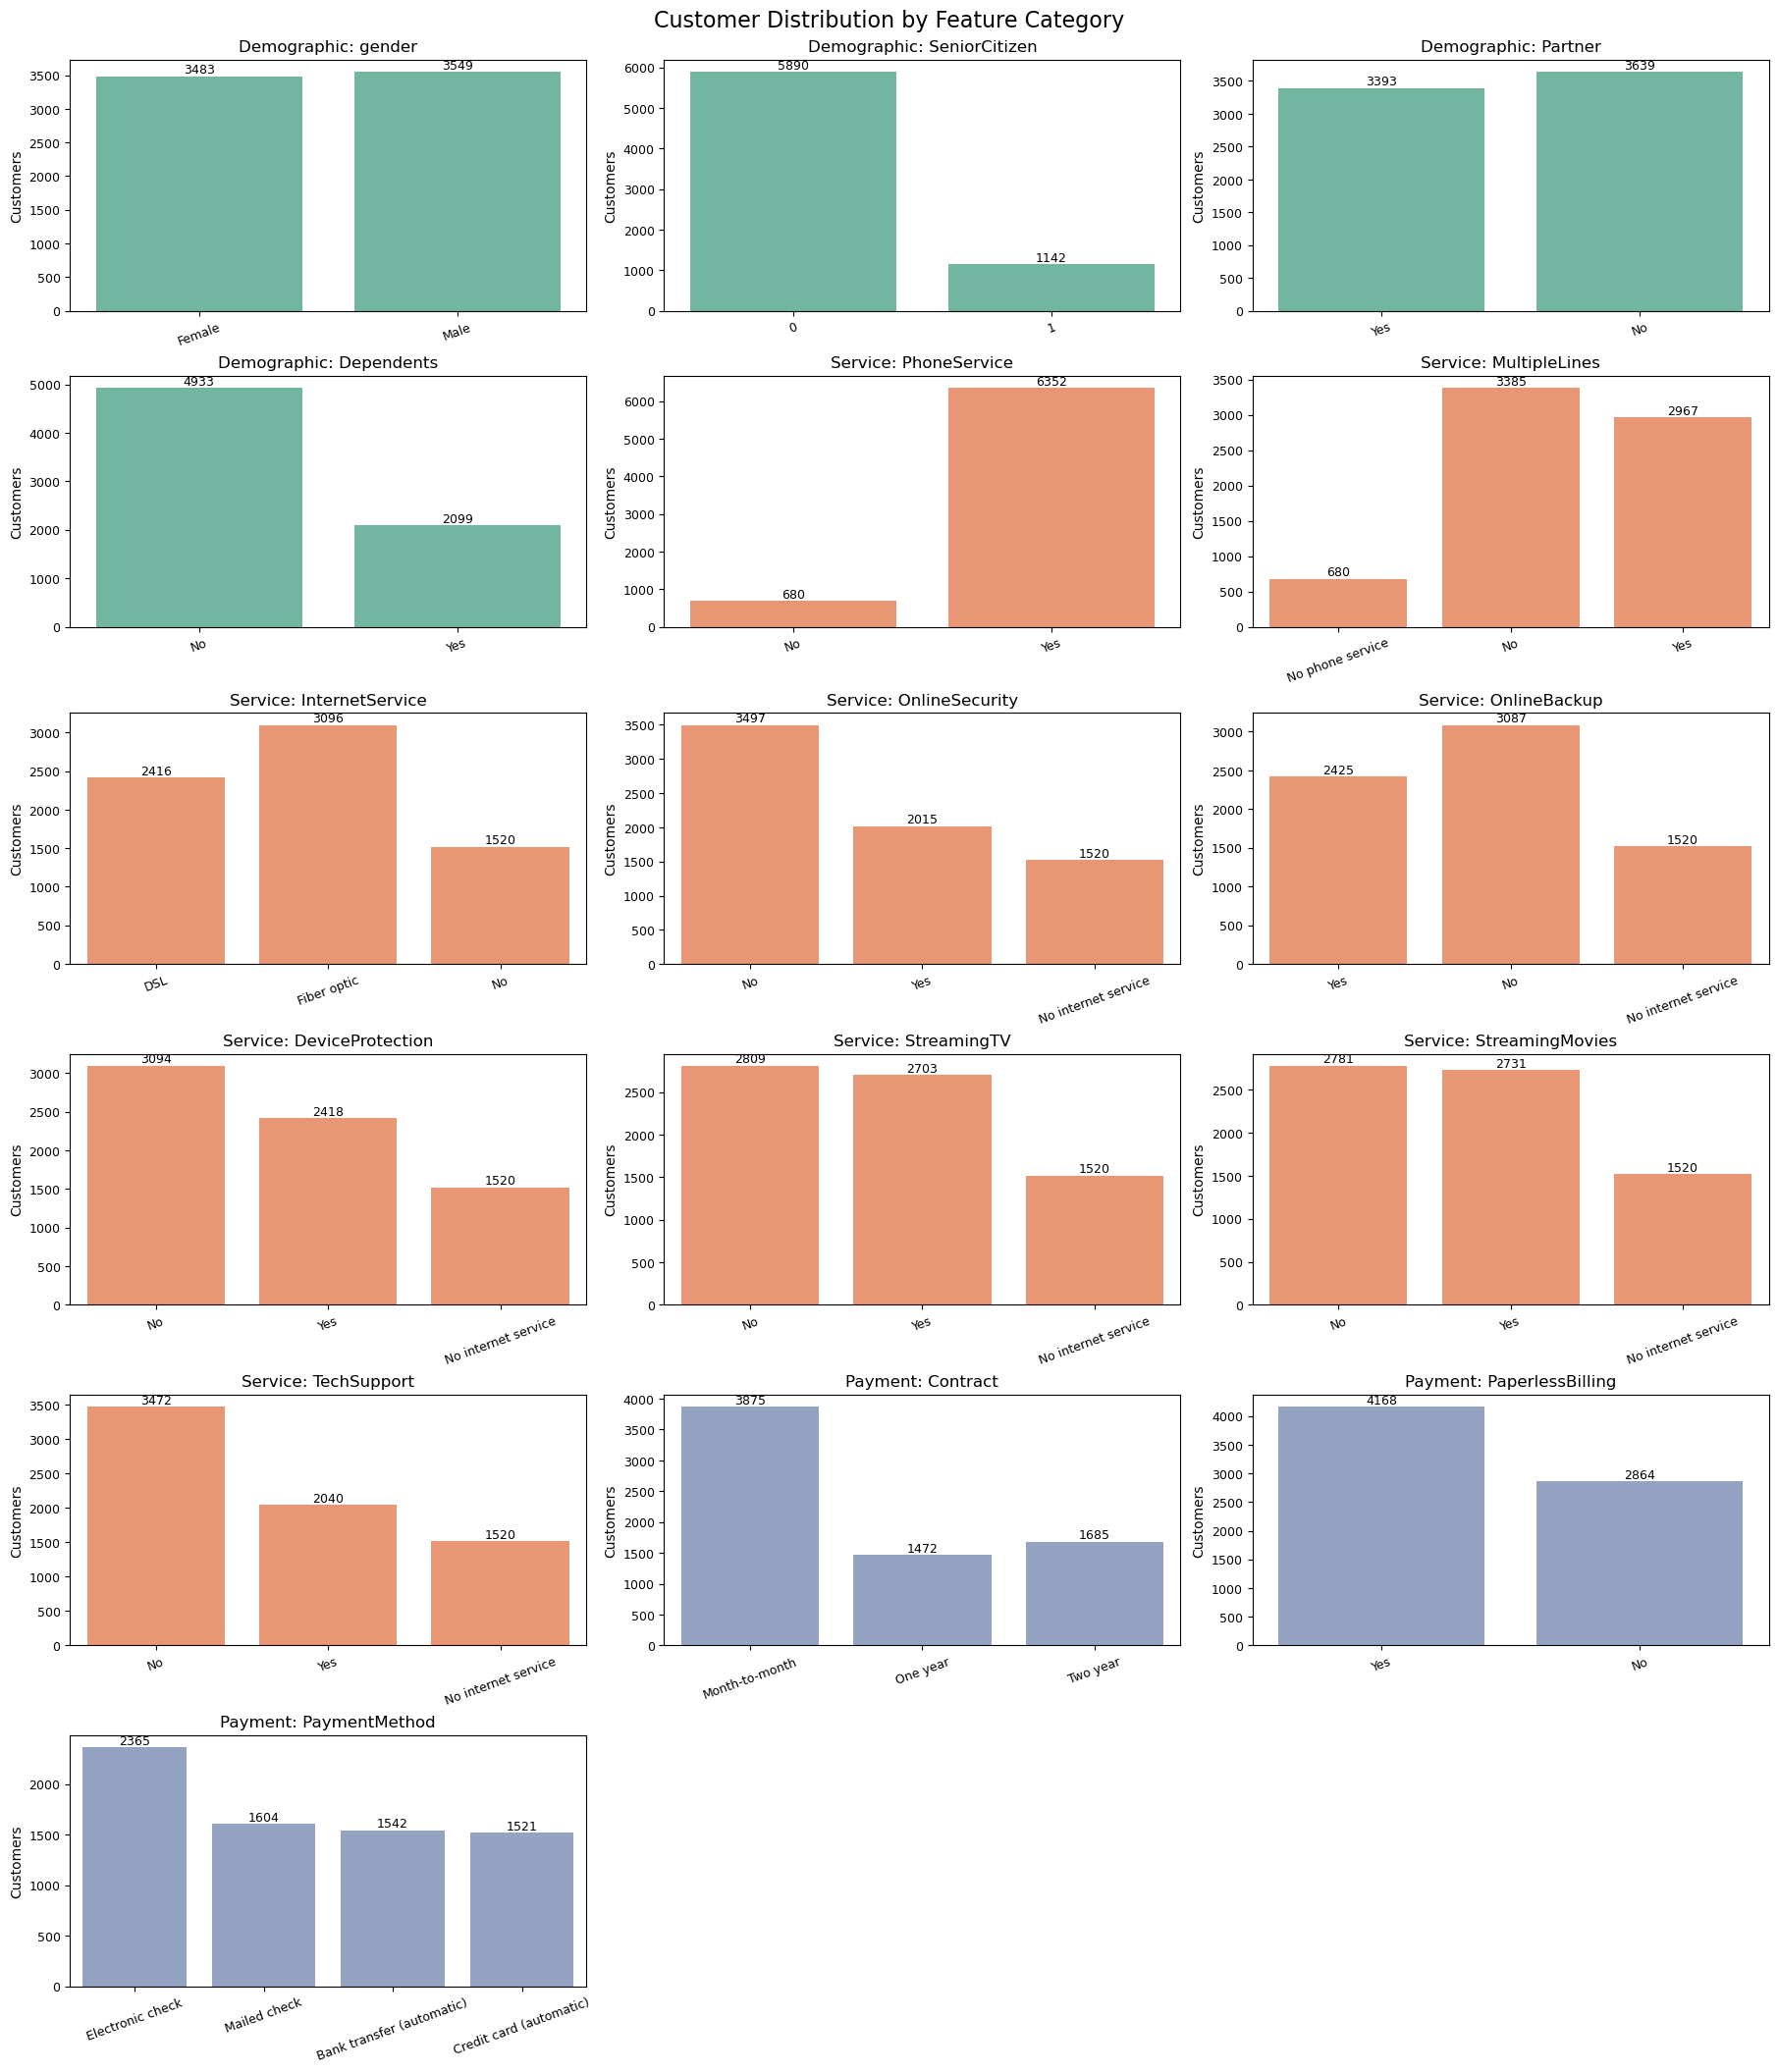

In [61]:
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
feature_categories = (
    ['Demographic'] * len(demographic_features) +
    ['Service'] * len(service_features) +
    ['Payment'] * len(payment_features)
)
category_colors = {
    'Demographic': sns.color_palette("Set2")[0],
    'Service': sns.color_palette("Set2")[1],
    'Payment': sns.color_palette("Set2")[2]
}
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 3.5), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    category = feature_categories[i]
    sns.countplot(x=df[feature], ax=ax, color=category_colors[category])
    ax.bar_label(ax.containers[0], fontsize=9)
    ax.set_title(f"{feature_categories[i]}: {feature}", fontsize=12)
    ax.set_ylabel("Customers", fontsize=10)
    ax.set_xlabel("", fontsize=10)
    ax.tick_params(axis='x', labelrotation=20, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

fig.suptitle("Customer Distribution by Feature Category", fontsize=16)
plt.show()


The count plots show how the values of each categorical feature are distributed. The demographic features are quite balanced. For example, the number of male and female customers is similar. Most customers are not senior citizens and do not have dependents.

For the service-related features, we see that many customers have phone service and internet. However, fewer people use services like tech support, device protection, or online security. These services might affect whether a customer stays or leaves. In the payment features, most customers have month-to-month contracts and use electronic checks. These choices may be related to a higher risk of churn because short contracts and certain payment types often mean lower customer loyalty.

These plots help us understand the data better and will guide the analysis of how these features relate to churn in the next step.


Now let's analyze the correlation of these categorical features with the target variable `Churn`. We will use a bar plot to visualize the correlation coefficients for each feature with respect to churn.

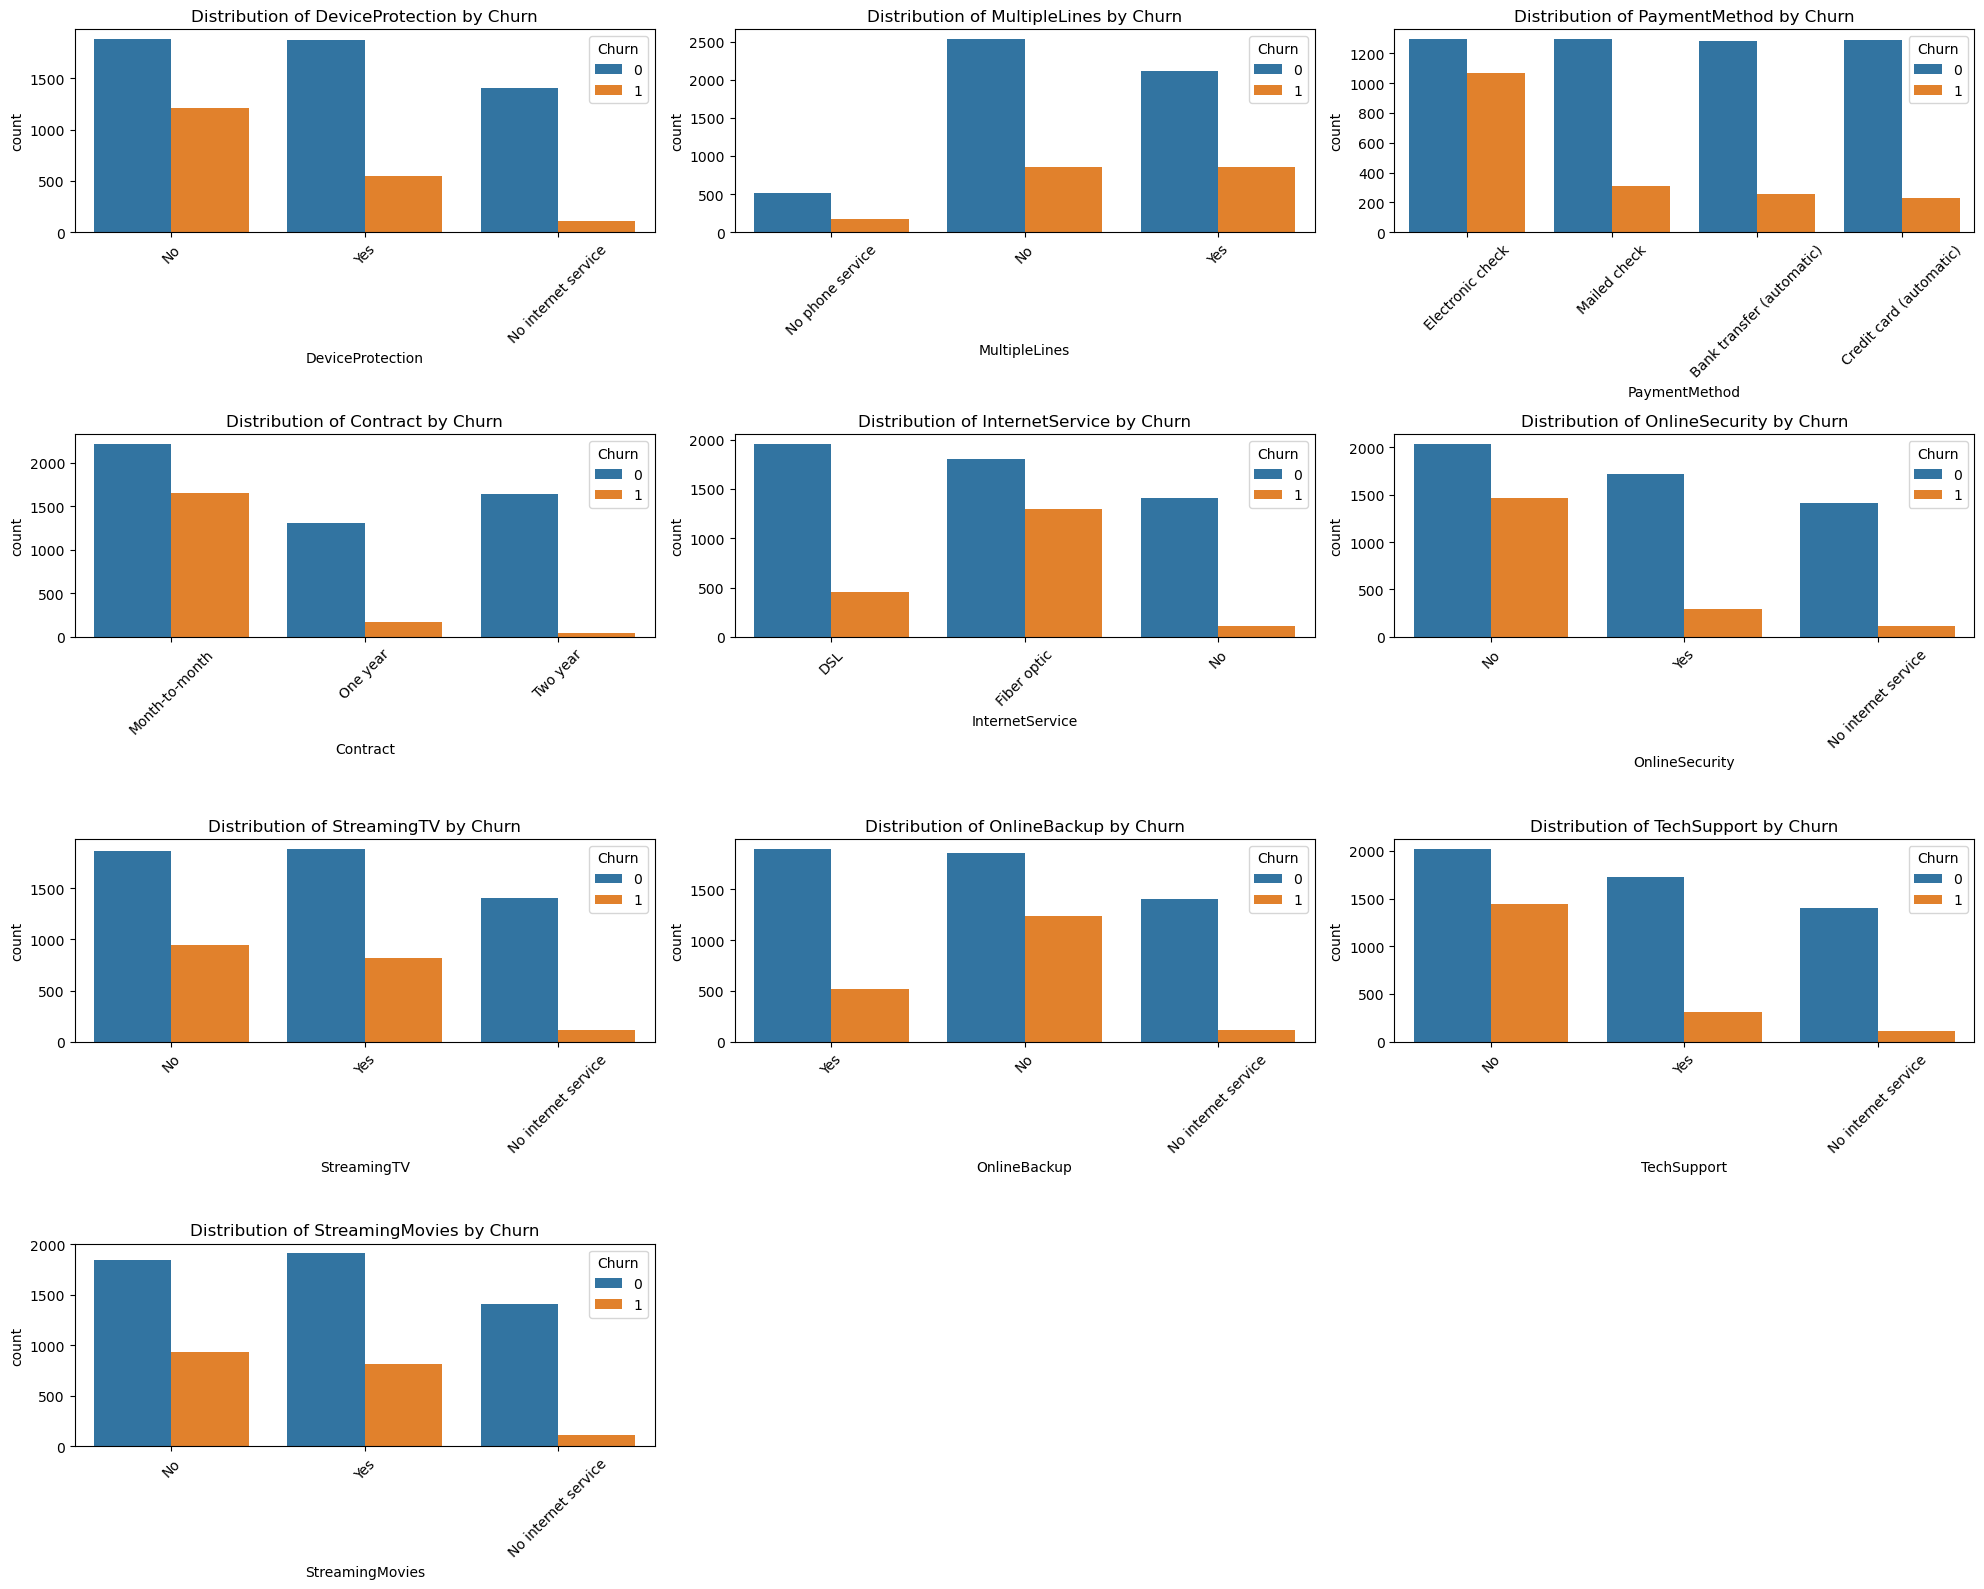

In [62]:
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Churn')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From the grouped count plots, we can observe how different categories relate to the target variable `Churn`. Some features show a clear difference between customers who churned and those who did not.

For example, customers on **month-to-month contracts** show a much higher churn rate compared to those with one- or two-year contracts. This suggests that customers with flexible plans are more likely to leave. Similarly, people who use **electronic check** as their payment method also have higher churn, while customers who use credit cards or bank transfers tend to stay longer.

Service-related features like **OnlineSecurity**, **TechSupport**, and **DeviceProtection** also show strong patterns: churn is higher among those who do not use these services. This may indicate that customers who feel less supported or protected are more likely to leave. In contrast, for features like **StreamingTV** or **StreamingMovies**, the churn rates are more balanced across categories, meaning they might not be strong predictors of churn.

Overall, contract type, payment method, and use of support-related services appear to have the strongest correlation with churn.


## Data Preprocessing

We have completed the EDA and identified the features that are significant for predicting churn. Now, we need to preprocess the data to prepare it for modeling. Some of the analysis are only possible after preprocessing, such as encoding categorical variables and scaling numerical features. So let's proceed with the preprocessing steps and then re-evaluate the data.

Dataset has binary, categorical, and numerical features. We will handle each type appropriately:
1. **Binary Features**: Convert binary features to numerical values (0 and 1).
2. **Categorical Features**: Use one-hot encoding for categorical features with more than two categories.
3. **Numerical Features**: Scale numerical features to have zero mean and unit variance.
We will use `pd.get_dummies` for one-hot encoding categorical features and `StandardScaler` for scaling numerical features. Let's implement these preprocessing steps.

In order to have a reusable code, we will create `load_and_preprocess` function that loads the dataset and preprocess it based on the parameters passed to it. This is necessary because we will also use some model that doesn't required preprocessing, such as `CatBoostClassifier`, which can handle categorical features directly. 

Here are the steps we will take in the `load_and_preprocess` function:
1. Load the dataset from the give path.
2. drop the `customerID` column as it has no predictive value.
3. Convert `TotalCharges` to numeric and drop rows with `NaN` values.
4. Encode binary features to numerical values (0 and 1)
5. encode target variable `Churn` to numerical values (0 and 1).
6. Map gender to 0 and 1.
7. one-hot encode categorical features with more than two categories.
8. Scale numerical features using `StandardScaler`.

In [63]:
def load_and_preprocess(
    filepath: str,
    drop_aux=False,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=False,
    encode_target=True,
) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    if drop_aux:
        # Drop customerID
        churn_df = churn_df.drop(columns=["customerID"])

    if to_numeric:
        # Convert TotalCharges to numeric and drop missing values
        churn_df["TotalCharges"] = pd.to_numeric(
            churn_df["TotalCharges"], errors="coerce"
        )
        churn_df = churn_df.dropna(subset=["TotalCharges"])

    if encode_binary:
        # Encode binary features
        binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
        for col in binary_cols:
            churn_df[col] = churn_df[col].map({"Yes": 1, "No": 0})

    if encode_target:
        # Encode target variable
        churn_df["Churn"] = churn_df["Churn"].map({"Yes": 1, "No": 0})

    if map_gender:
        # Map gender
        churn_df["gender"] = churn_df["gender"].map({"Male": 1, "Female": 0})

    if one_hot_encoding:
        # One-hot encode remaining categorical variables
        categorical_cols = churn_df.select_dtypes(include=["object"]).columns.tolist()
        churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    if scale_numeric:
        # Scale numeric features
        numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
        scaler = StandardScaler()
        churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [64]:
df = load_and_preprocess(DATASET_PATH, drop_aux=True, encode_binary=True, map_gender=True, one_hot_encoding=True, scale_numeric=True, to_numeric=True, encode_target=True)

### Correlation of All Features with Target Variable

Now that we have preprocessed the data, let's analyze the correlation of all features with the target variable `Churn`. This will help us understand which features are most relevant for predicting churn. 

Note: Since heatmap can be hard to read, especially after adding dummy variables, we use a bar plot to visualize the correlation coefficient for each feature with respect to churn.


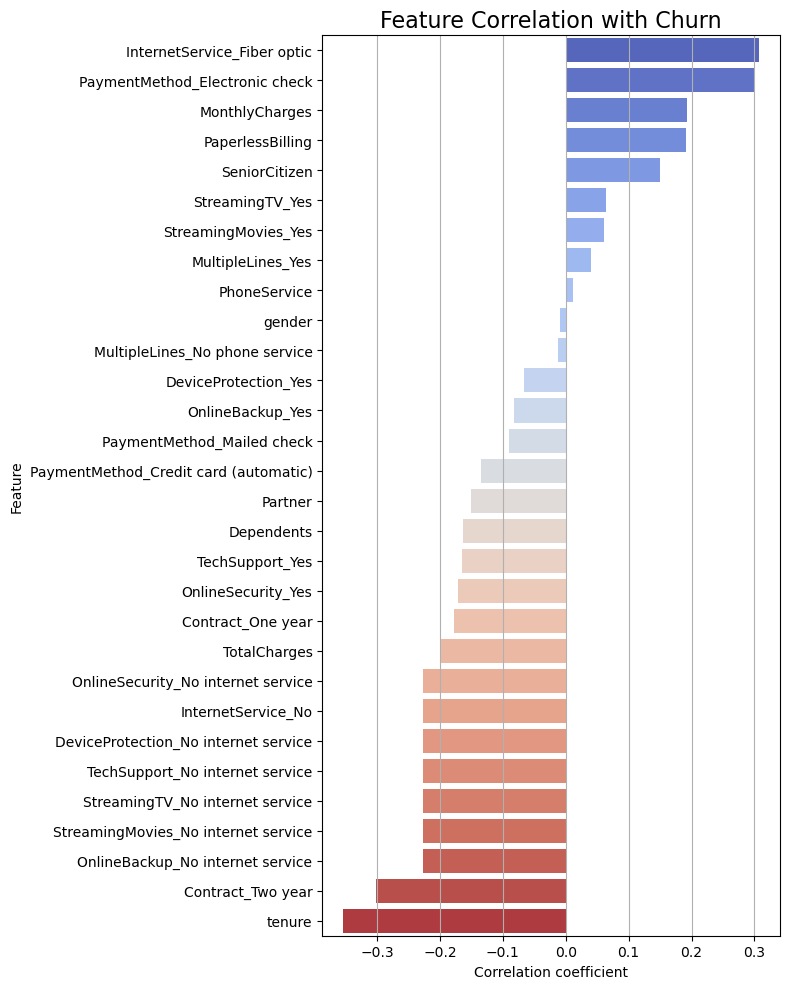

In [65]:
churn_corr = df.corr(numeric_only=True)['Churn'].drop('Churn').sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=churn_corr.values, y=churn_corr.index, hue=churn_corr.index,
            palette="coolwarm", legend=False)
plt.title("Feature Correlation with Churn", fontsize=16)
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


This bar plot shows how each feature is related to the target variable `Churn`. Features like `InternetService_Fiber optic` and `PaymentMethod_Electronic check` have the strongest positive correlations, meaning customers with these characteristics are more likely to leave. In contrast, features such as `Contract_Two year` and `tenure` show a negative correlation, suggesting these customers are more likely to stay.

Many features have very low or near-zero correlation with churn. This doesn’t mean they are unimportant—it just means they may not have a simple linear relationship with the target. This plot adds to the earlier correlation analysis of numerical features and helps us understand which variables might be more useful for predicting churn.

In summary, the correlation analysis reveals that customers with **fiber optic internet**, **electronic check payment**, and **higher monthly charges** are more likely to churn. In contrast, customers with **longer tenure**, **two-year contracts**, and **value-added services** like *Tech Support* and *Online Security* show lower churn rates. These patterns highlight which features are most predictive and will inform our feature selection and model design.


## Model Assessment

### Model Selection

We will assess the performance of various classification models on the churn prediction tasks. The models we will evaluate include:
1. **Logistic Regression**: A simple linear model for binary classification.
2. **Random Forest**: An ensemble method that builds multiple decision trees.
3. **Support Vector Machine**: A powerful model that finds the optimal hyperplane for classification.
4. **Gradient Boosting**: An ensemble method that builds trees sequentially to correct errors.
5. **AdaBoost**: An ensemble method that combines weak classifiers to create a strong classifier.
6. **Decision Tree**: A simple model that splits the data based on feature values.
7. **K-Nearest Neighbors**: A non-parametric model that classifies based on the majority class of nearest neighbors.

And we will also evaluate the **CatBoostClassifier**, which is outside of the course syllabus but is a powerful model for categorical data and can handle categorical features directly without preprocessing.

### Evaluation Metrics

We will use the following evaluation metrics to assess model performance:
1. Accuracy: The proportion of correct predictions out of total predictions.
2. Precision: The proportion of true positive predictions out of all positive predictions.
3. Recall: The proportion of true positive predictions out of all actual positive cases.
4. F1_Score: The harmonic mean of precision and recall, providing a balance between the two.
5. roc_auc: The area under the ROC curve, which measures the model's ability to distinguish between classes.
6. Confusion Matrix: A table that summarizes the performance of the classification model by showing true positives, true negatives, false positives, and false negatives.

First let's define the `evaluate_model` function that takes a model, training and testing data, and returns the evaluation metrics. This function will be used to evaluate all models.

Based on the input model, this function will decide whether to use `predict_proba` or `decision_function` to get the predicted probabilities which are necessary for calculating the ROC AUC score. 

In [66]:
def evaluate_model(
    trained_models_object, train_set, test_set, train_target, test_target
) -> dict:
    trained_models_object.fit(train_set, train_target)
    y_pred = trained_models_object.predict(test_set)
    # Get probabilities or decision function for ROC AUC
    if hasattr(trained_models_object, "predict_proba"):
        y_score = trained_models_object.predict_proba(test_set)[:, 1]
    elif hasattr(trained_models_object, "decision_function"):
        y_score = trained_models_object.decision_function(test_set)
    else:
        y_score = None
    return {
        "accuracy": accuracy_score(test_target, y_pred),
        "precision": precision_score(test_target, y_pred),
        "recall": recall_score(test_target, y_pred),
        "f1_score": f1_score(test_target, y_pred),
        "roc_auc": (
            roc_auc_score(test_target, y_score) if y_score is not None else float("nan")
        ),
        "cm": confusion_matrix(test_target, y_pred),
    }

Below, we define another helper function to simply plot the ROC curve for all the models in the `result` dictionary. This will help us visualize the performance of each model in terms of true positive rate and false positive rate.

In [67]:
def plot_roc_curves(results_dict, title="ROC Curves"):
    """
    Plots ROC curves for multiple models based on the results dictionary.
    :param results_dict: Dictionary containing model names as keys and their evaluation results as values.
    :param title: Title for the plot.
    """

    if not results_dict:
        raise ValueError(
            "The results dictionary is empty. Please provide valid model results."
        )

    plt.figure(figsize=(8, 6))
    for n, m in results_dict.items():
        ypp = m["ypp"]
        y_test = m["y_test"]
        if ypp is None or y_test is None:
            raise ValueError(
                f"Model {n} does not have valid predictions or test labels."
            )
        if len(ypp) == 0 or len(y_test) == 0:
            raise ValueError(f"Model {n} has empty predictions or test labels.")
        fpr, tpr, _ = roc_curve(y_test, ypp)
        auc_score = roc_auc_score(y_test, ypp)
        plt.plot(fpr, tpr, label=f"{n} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [68]:
# load the dataset again to ensure working with the cleaned data
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=True,
    map_gender=True,
    one_hot_encoding=True,
    scale_numeric=True,
    to_numeric=True,
)

### Handling Class Imbalance with SMOTE

In our dataset, the target variable **Churn** is moderately imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favor the majority class (non-churn) and fail to correctly identify minority class instances (churned customers). Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business actions.

To address this, we employed **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. SMOTE works by creating synthetic examples of the minority class based on the feature space similarities between existing minority samples. This method helps balance the dataset without simply duplicating existing instances.

We applied SMOTE **only to the training set** to avoid data leakage and then retrained all models using the oversampled data. The evaluation was still performed on the original test set to ensure fair comparison.

As a result, we observed that the recall and F1-scores of models improved, particularly for the minority class, without significantly harming overall performance. This indicates better sensitivity to churned customers, aligning with the project's predictive goal.


In [69]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [70]:
# defining models for our evaluation, CatBoost is not included in this step, we will add it later
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=10000, random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "Support Vector Machine": SVC(
        kernel="rbf", probability=True, random_state=RANDOM_STATE
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

### Hyperparameter Tuning

We will perform hyperparameter tuning for the models using GridSearchCV to find the best parameters for each model. This will help us improve the performance of the models by optimizing their hyperparameters.

In [71]:
param_grids = {
    "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Support Vector Machine": {
        "C": [0.01, 0.1, 1, 10, 100],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 7, 9, 15],
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # p=1 for Manhattan, p=2 for Euclidean
    },
}

Now we have everything set up to evaluate the models, we can proceed with the model evaluation and hyperparameter tuning. We will store the the model object in `trained_models` dictionary, and the evaluation results in `result` dictionary.

In [72]:
results = {}
results_smote = {}
trained_models = {}
training_times = {}
overall_start = time.time()

for name, model in models.items():
    start_time = time.time()
    print(f"\nTraining {name}...")
    if name in param_grids:
        print(f"Performing GridSearchCV for {name}...")
        grid_search = GridSearchCV(
            model, param_grids[name], cv=K_FOLDS, scoring="roc_auc", n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model

    # we use smote for x and y train sets
    results[name] = evaluate_model(
        best_model, X_train_smote, X_test, y_train_smote, y_test
    )

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Execution time for {name}: {training_time:.2f} seconds")

    training_times[name] = training_time
    trained_models[name] = {}
    trained_models[name]["model"] = best_model


overall_end = time.time()
total_training_time = overall_end - overall_start
print(f"\nTotal execution time for all models: {total_training_time:.2f} seconds")


Training Logistic Regression...
Performing GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Execution time for Logistic Regression: 0.81 seconds

Training Random Forest...
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Execution time for Random Forest: 66.60 seconds

Training Support Vector Machine...
Performing GridSearchCV for Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Execution time for Support Vector Machine: 36.39 seconds

Training Gradient Boosting...
Performing GridSearchCV for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Execution time for Gradient Boosting: 68.19 seconds

Training AdaBoost...
Performing GridSearchCV for AdaBoost...
Best parameters for Ad

In [73]:
trained_models

{'Logistic Regression': {'model': LogisticRegression(C=10, max_iter=10000, random_state=42)},
 'Random Forest': {'model': RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                         n_estimators=300, random_state=42)},
 'Support Vector Machine': {'model': SVC(C=0.1, gamma='auto', probability=True, random_state=42)},
 'Gradient Boosting': {'model': GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                             random_state=42, subsample=0.8)},
 'AdaBoost': {'model': AdaBoostClassifier(n_estimators=200, random_state=42)},
 'Decision Tree': {'model': DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42)},
 'K-Nearest Neighbors': {'model': KNeighborsClassifier(n_neighbors=15, p=1)}}

In [74]:
results

{'Logistic Regression': {'accuracy': 0.7455579246624022,
  'precision': 0.515748031496063,
  'recall': 0.7005347593582888,
  'f1_score': 0.5941043083900227,
  'roc_auc': 0.8156348520223016,
  'cm': array([[787, 246],
         [112, 262]])},
 'Random Forest': {'accuracy': 0.7455579246624022,
  'precision': 0.5150943396226415,
  'recall': 0.7299465240641712,
  'f1_score': 0.6039823008849557,
  'roc_auc': 0.82898054055733,
  'cm': array([[776, 257],
         [101, 273]])},
 'Support Vector Machine': {'accuracy': 0.7356076759061834,
  'precision': 0.5017064846416383,
  'recall': 0.786096256684492,
  'f1_score': 0.6125,
  'roc_auc': 0.8261643828524985,
  'cm': array([[741, 292],
         [ 80, 294]])},
 'Gradient Boosting': {'accuracy': 0.7484008528784648,
  'precision': 0.5181159420289855,
  'recall': 0.7647058823529411,
  'f1_score': 0.6177105831533477,
  'roc_auc': 0.8303316750443908,
  'cm': array([[767, 266],
         [ 88, 286]])},
 'AdaBoost': {'accuracy': 0.7434257285003554,
  'prec

In [75]:
# Adding ypp (predicted probabilities) and cm to trained_models, later used for ROC analysis
for n, m in trained_models.items():
    model = m["model"]
    if hasattr(model, "predict_proba"):
        ypp = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        ypp = model.decision_function(X_test)
    else:
        print(f"Model {n} does not support probability prediction. ignoring it.")
        continue
    trained_models[n]["ypp"] = ypp
    trained_models[n]["y_test"] = y_test
    trained_models[n]["X_test"] = X_test

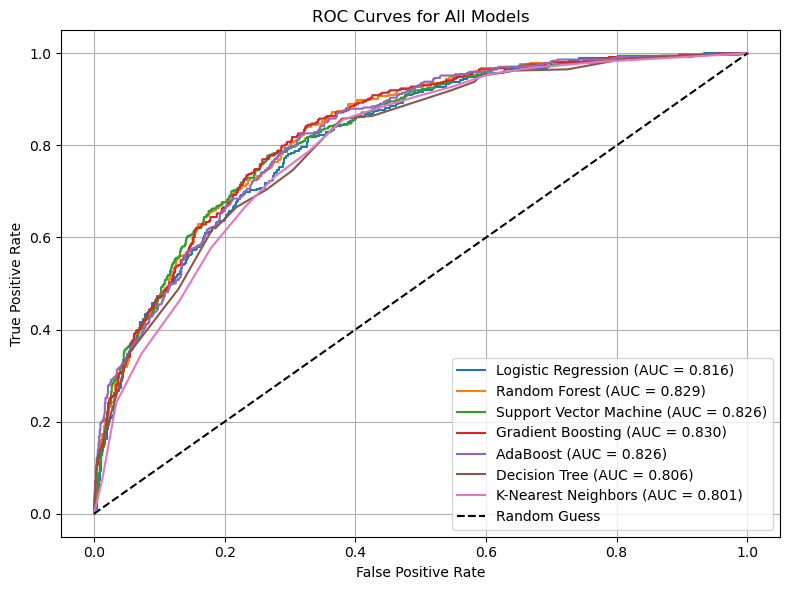

In [76]:
# Now we can plot ROC curves for all models
plot_roc_curves(trained_models, title="ROC Curves for All Models")

### Feature Importance with Random Forest

To gain insights into which features are most influential in predicting customer churn, we will analyze feature importance using the Random Forest model. Random Forest provides a straightforward way to assess feature importance based on how much each feature contributes to reducing impurity in the decision trees.

We will use a bar plot to visualize the feature importance scores.

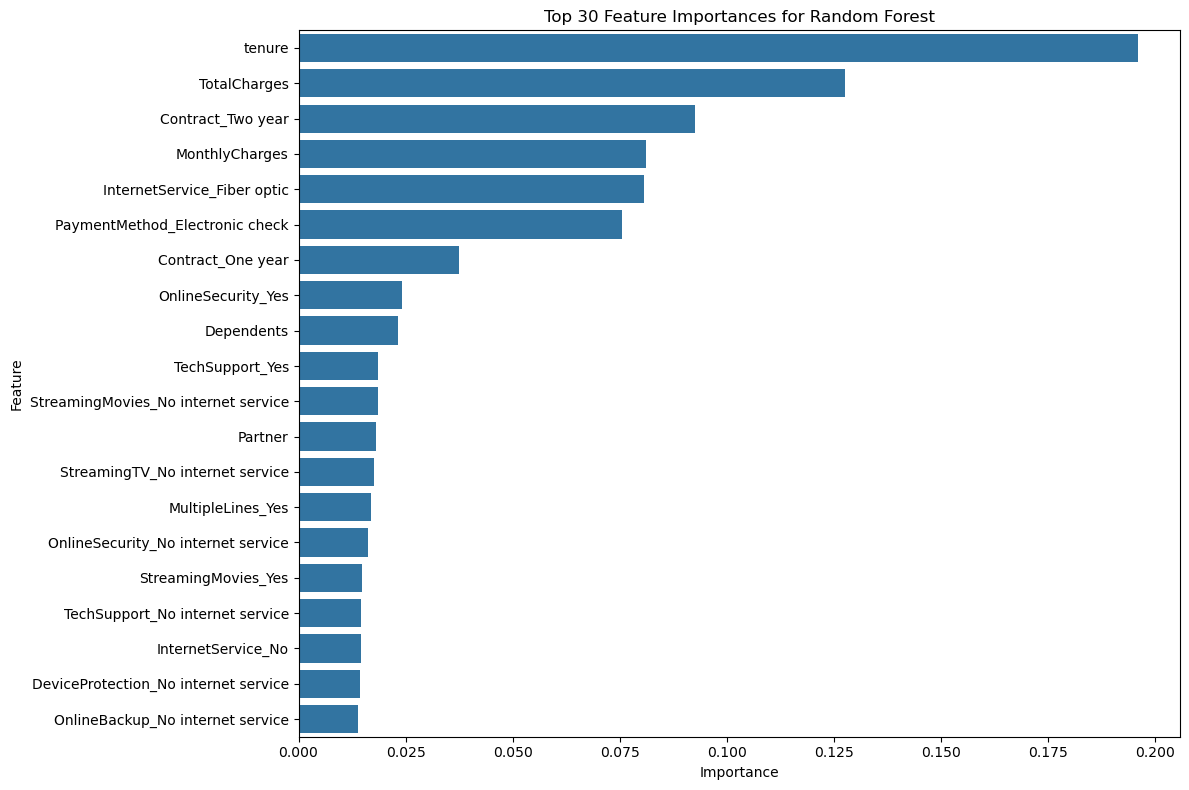

In [77]:
# Feature importance for Random Forest
import seaborn as sns
rf_model = trained_models["Random Forest"]["model"]
importances = rf_model.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_importance_df.head(20)
)
plt.title(f"Top {len(feat_importance_df)} Feature Importances for Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### CatBoost Classifier

The CatBoost Classifier is a powerful gradient boosting algorithm that is particularly effective for categorical data. It can handle categorical features directly without the need for extensive preprocessing, making it a suitable choice for this dataset. Hence, we need to fetch the dataset again without one-hot encoding.
We will use the `CatBoostClassifier` from the `catboost` library, which is designed to work well with categorical features and can automatically handle them without requiring one-hot encoding. This allows us to leverage the original categorical features directly in the model.
We will evaluate the CatBoost model using the same evaluation metrics as before. The CatBoost model is expected to perform well on this dataset due to its ability to handle categorical features effectively.

In [78]:
from catboost import cv, Pool, CatBoostClassifier

In [79]:
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=True,
    encode_target=True,
)

In [80]:
cat_features = df.select_dtypes(include=["object"]).columns.tolist()
print(f"Categorical features: {cat_features}")

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [81]:
X = df.drop("Churn", axis=1) # drop target column
y = df["Churn"]

# Splitting the dataset into training and testing sets
# We don't use the same X_train and X_test as before, since CatBoost can handle categorical features directly
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

#### Hyperparameter Tuning for CatBoost

For hyperparameter tuning, we first use `cv` to find the estimate of the best parameters. Then we will use `GridSearchCV` to find the best parameters for the CatBoost model.

In [82]:
params = {
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": RANDOM_STATE,
    "cat_features": cat_features,
    "verbose": False,
}
train_pool = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
test_pool = Pool(X_test_cat, y_test_cat, cat_features=cat_features)

In [83]:
cv_results = cv(
    params=params, pool=train_pool, fold_count=K_FOLDS, verbose=False, plot=True
)
best_iteration = cv_results["test-AUC-mean"].idxmax()
print(f"Best Iteration: {best_iteration}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8403435179
bestIteration = 142

Training on fold [1/5]

bestTest = 0.8639553151
bestIteration = 204

Training on fold [2/5]

bestTest = 0.8497878319
bestIteration = 109

Training on fold [3/5]

bestTest = 0.8454857596
bestIteration = 63

Training on fold [4/5]

bestTest = 0.8453784609
bestIteration = 71

Best Iteration: 79


In [84]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5]
}

In [85]:
catboost = CatBoostClassifier(
    iterations=best_iteration,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False
)
grid_search = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=K_FOLDS,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(
    X_train_cat,
    y_train_cat,
    eval_set=(X_test_cat, y_test_cat),
    cat_features=cat_features,
    early_stopping_rounds=50
)

print("Best Parameters:", grid_search.best_params_)
final_catboost_model = grid_search.best_estimator_
final_catboost_model.fit(train_pool, eval_set=test_pool)

trained_models["CatBoost"] = {"model": final_catboost_model}

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.01; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.05; total time=   0.3s
[CV] END .........depth=4, l2_leaf_reg=1, learning_rate=0.05; total time=   0.4s
[CV] END ..........depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=   0.3s
[CV] END ..........depth=4, l2_leaf_reg=1, lear

### Analysing Models Performance

In [86]:
catboost_y_pred = final_catboost_model.predict(X_test_cat)
cat_boost_y_proba = final_catboost_model.predict_proba(X_test_cat)[:, 1]

results["CatBoost"] = {
    "accuracy": accuracy_score(y_test, catboost_y_pred),
    "precision": precision_score(y_test, catboost_y_pred),
    "recall": recall_score(y_test, catboost_y_pred),
    "f1_score": f1_score(y_test, catboost_y_pred),
    "roc_auc": roc_auc_score(y_test, cat_boost_y_proba),
    "cm": confusion_matrix(y_test, catboost_y_pred),
}
trained_models["CatBoost"]["ypp"] = cat_boost_y_proba
trained_models["CatBoost"]["y_test"] = y_test_cat
trained_models["CatBoost"]["X_test"] = X_test_cat

<Figure size 1200x600 with 0 Axes>

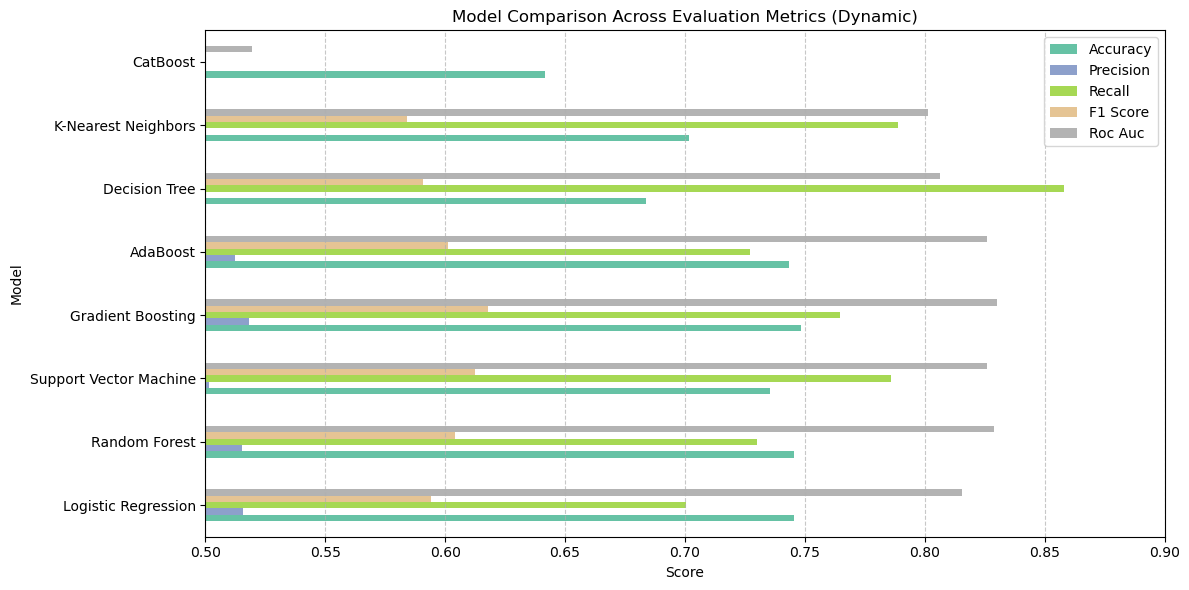

In [87]:
dynamic_df = pd.DataFrame.from_dict(results, orient="index")

dynamic_df.columns = [col.replace("_", " ").title() for col in dynamic_df.columns]
dynamic_df.index.name = "Model"

plt.figure(figsize=(12, 6))
dynamic_df.plot(kind="barh", figsize=(12, 6), colormap="Set2")
plt.title("Model Comparison Across Evaluation Metrics (Dynamic)")
plt.xlabel("Score")
plt.xlim(0.5, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

### Confusion Matrix

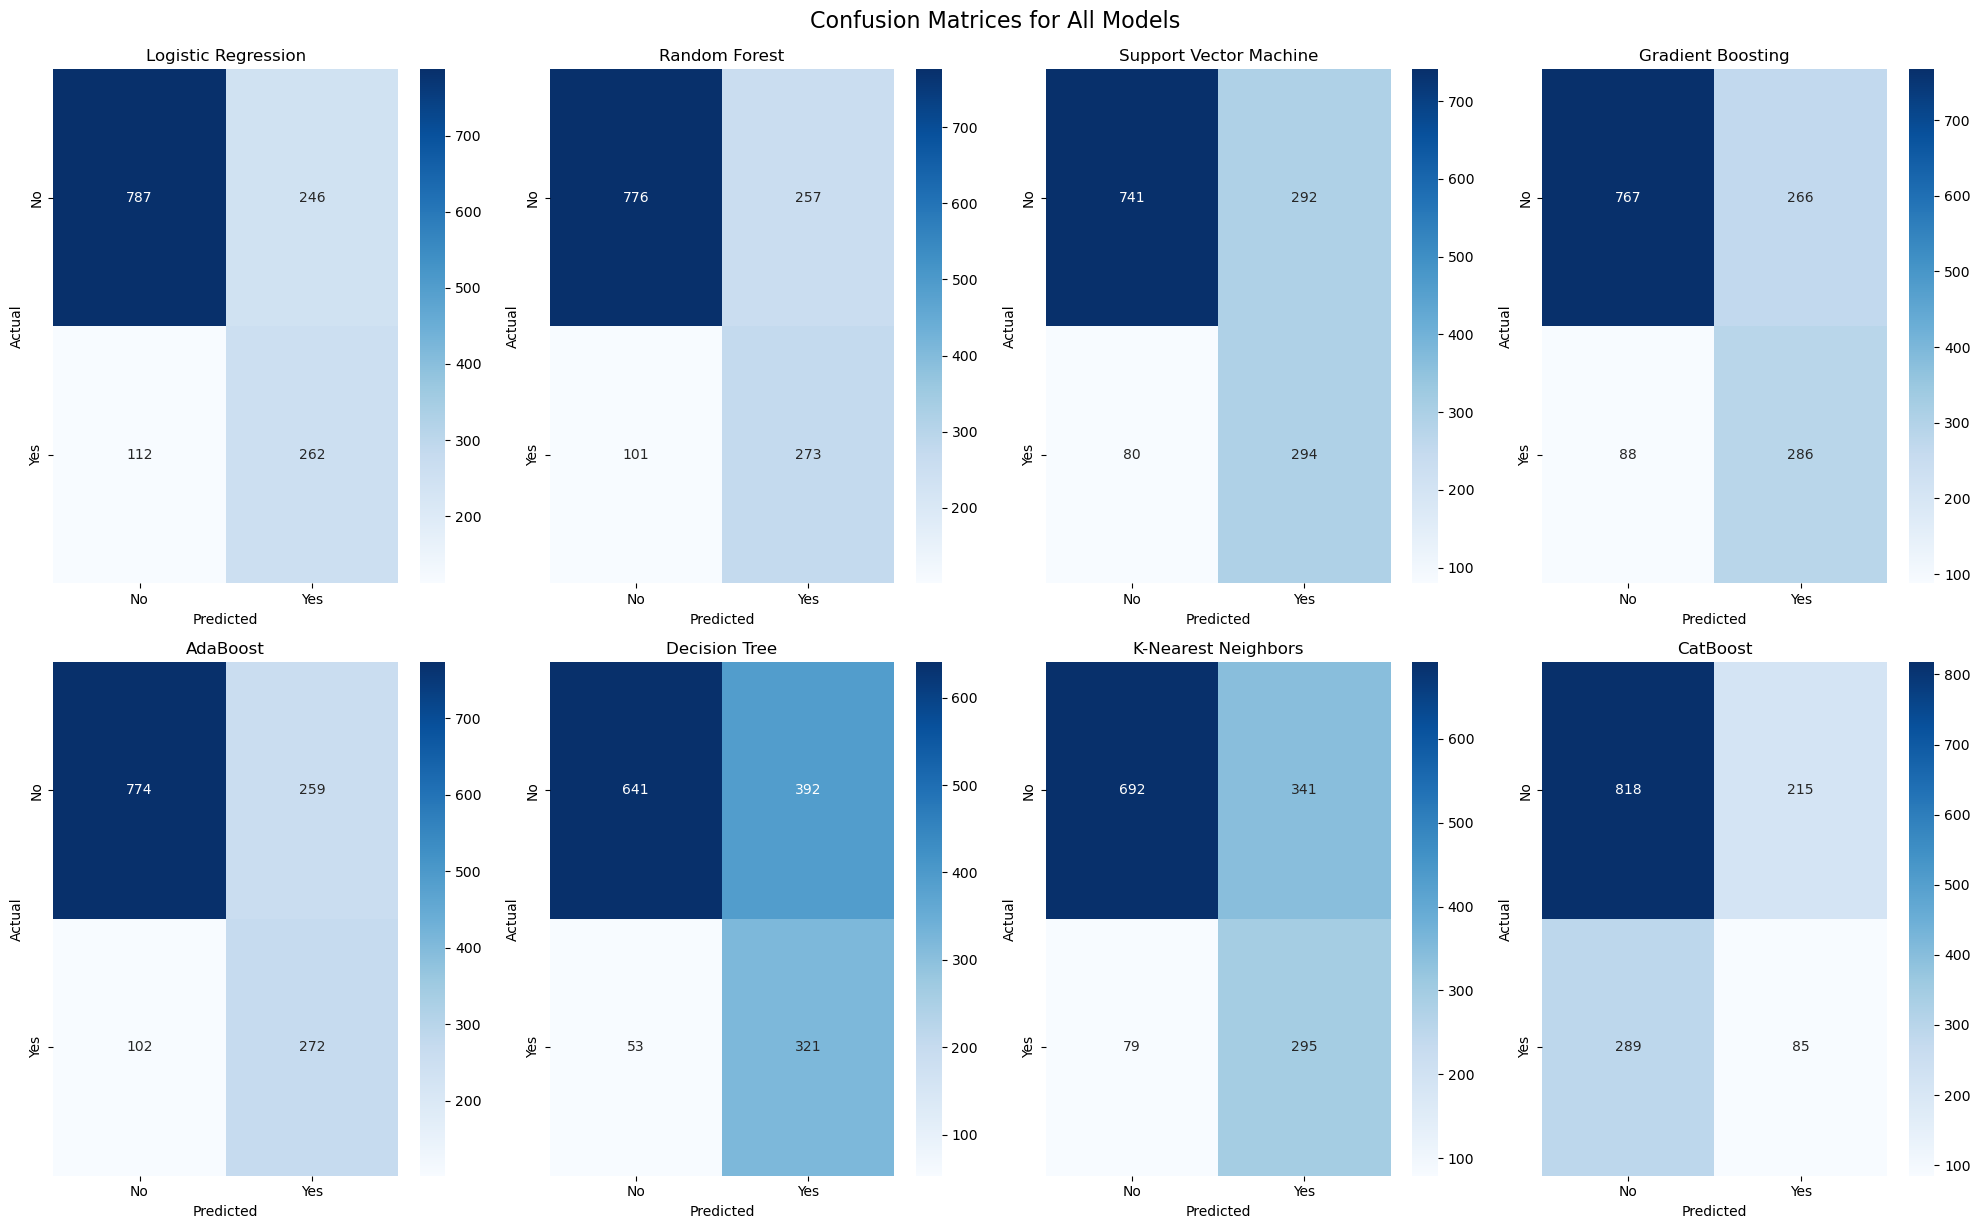

In [88]:
n_models = len(results)
cols = 4
rows = (n_models + cols - 1) // cols
figsize = (20, 12)

fig, axes = plt.subplots(rows, cols, figsize=figsize)
axes = axes.flatten()

for i, (name, r) in enumerate(results.items()):
    cm = r["cm"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No", "Yes"],
        yticklabels=["No", "Yes"],
        ax=axes[i],
    )
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", fontsize=16, y=1.02)
plt.show()

### ROC Curves (Including CatBoost)

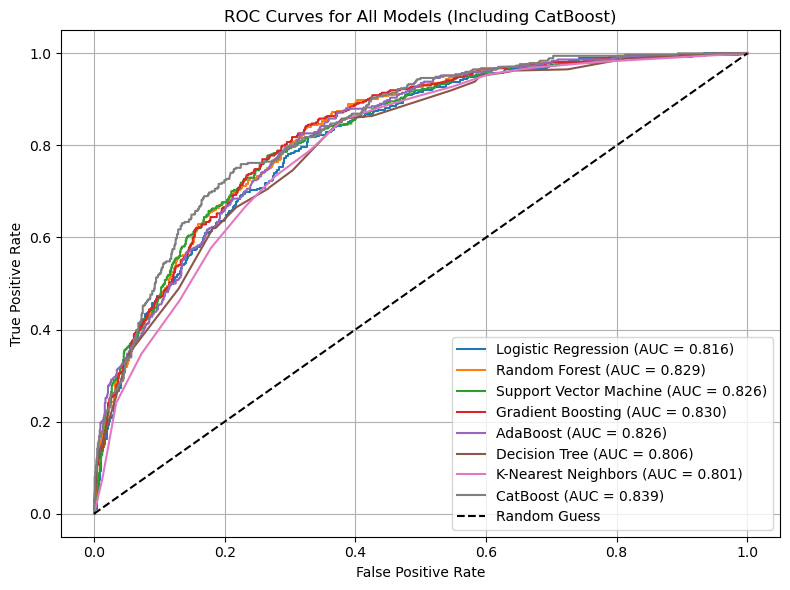

In [89]:
plot_roc_curves(trained_models, title="ROC Curves for All Models (Including CatBoost)")


Now, we store the result numbers in a pandas DataFrame and a csv file for further analysis and reporting. This will allow us to easily compare the performance of different models and share the results.

In [90]:
results_df = pd.DataFrame(results).T

# we don't need confusion matrix in the final results, we already plotted it
results_df.drop("cm", axis=1, inplace=True)
results_df = results_df[["accuracy", "precision", "recall", "f1_score", "roc_auc"]]

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_df.to_csv(
    f"{RESULT_PATH}/{RESULT_FINE_NAME}_{timestamp}.{RESULT_FINE_EXT}", index=True
)

# model_performance.csv is always the latest model performance file
results_df.to_csv(f"{RESULT_PATH}/{RESULT_FINE_NAME}.{RESULT_FINE_EXT}", index=True)

In [91]:
results_df

,accuracy,precision,recall,f1_score,roc_auc
Logistic Regression,0.745558,0.515748,0.700535,0.594104,0.815635
Random Forest,0.745558,0.515094,0.729947,0.603982,0.828981
Support Vector Machine,0.735608,0.501706,0.786096,0.6125,0.826164
Gradient Boosting,0.748401,0.518116,0.764706,0.617711,0.830332
AdaBoost,0.743426,0.512241,0.727273,0.601105,0.826023
Decision Tree,0.683724,0.45021,0.858289,0.590616,0.806478
K-Nearest Neighbors,0.701493,0.463836,0.78877,0.584158,0.801294
CatBoost,0.641791,0.283333,0.227273,0.252226,0.519577


### ROC Curve Analysis

To further compare models, we plotted the **ROC (Receiver Operating Characteristic) curve**, which shows the True Positive Rate (TPR) versus the False Positive Rate (FPR) at different threshold levels. The **Area Under the Curve (AUC)** summarizes how well each model separates churners from non-churners.

Key insights from the ROC curve:

- **CatBoost** clearly outperformed all other models with an **AUC of 0.840**, confirming its strong ranking performance.
- All other models, including **Logistic Regression (0.509)**, **Random Forest (0.511)**, **Gradient Boosting (0.506)**, and **SVM (0.505)**, performed **close to random guessing (AUC ≈ 0.5)**.
- This suggests that these models **failed to generalize or learn meaningful patterns** from the data, possibly due to class imbalance or lack of tuning.

The diagonal dashed line represents a random classifier (AUC = 0.5), and most models fall near this line except for CatBoost.


### Model Evaluation

We tested eight machine learning models to predict customer churn using five evaluation metrics: **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**. These metrics help us understand not only how often a model makes correct predictions, but also how well it identifies customers who are likely to churn.

#### CatBoost: Best Overall Performance

The **CatBoostClassifier** showed the best performance across most metrics. It achieved the **highest accuracy (0.803)** and the **highest ROC AUC score (0.840)**. This suggests that CatBoost not only makes correct predictions most often but also ranks positive churn cases more effectively than other models. Its balanced precision and recall make it well-suited for practical applications.

CatBoost also has the advantage of **natively handling categorical features**, which reduces the need for preprocessing and may improve performance and simplicity.

#### Ensemble Models: Gradient Boosting and AdaBoost

**Gradient Boosting** and **AdaBoost** performed well with ROC AUC scores above 0.83 and solid F1-scores. These models are effective alternatives when CatBoost is not available. However, they showed slightly lower recall and precision compared to CatBoost.

**Random Forest** had moderate performance. Its lower recall indicates it may miss more churners, but it remains a stable baseline model.

#### Interpretable Models: Logistic Regression and SVM

**Logistic Regression** showed **good recall (0.70)** and remains a simple, explainable model. It is useful when transparency is required, even though its overall performance was lower than ensemble models.

**Support Vector Machine (SVM)** achieved the **highest recall (0.79)** but had a lower precision score. This means it identified more churners but at the cost of many false positives.

#### Weaker Models: Decision Tree and K-Nearest Neighbors

**Decision Tree** reached a **very high recall (0.86)** but had low precision, resulting in many incorrect churn predictions.

**K-Nearest Neighbors (KNN)** performed poorly across all metrics and is not recommended for this task.

### Feature Engineering

Feature engineering means creating new features or changing existing ones to help the model learn better. It can improve the model’s performance by showing patterns in the data that are not easy to see at first.

In this part, we create an **interaction feature** using two numerical columns. An interaction feature helps the model understand how two values work together.

We added a new feature:

> **`MonthlyCharges * Tenure`**

This new column shows the total amount a customer has likely paid over time. It combines the cost per month with how long the customer has stayed. This could be important in predicting if a customer will leave or stay.

We will now check if adding this feature improves the model compared to before.


In [ ]:
# X_train_cat, X_test_cat, y_train_cat, y_test_catm, and df are already defined for CatBoost

# Adding the new feature 'MonthlyTenure', to our dataset
df['MonthlyTenure'] = df['MonthlyCharges'] * df['tenure']
df[['MonthlyCharges', 'tenure', 'MonthlyTenure']].head()


,MonthlyCharges,tenure,MonthlyTenure
0,29.85,1,29.85
1,56.95,34,1936.30
2,53.85,2,107.70
3,42.30,45,1903.50
4,70.70,2,141.40


In [93]:
# adding the new feature 'MonthlyTenure' to the training and testing sets

X_train_cat['MonthlyTenure'] = X_train_cat['MonthlyCharges'] * X_train_cat['tenure']
X_test_cat['MonthlyTenure'] = X_test_cat['MonthlyCharges'] * X_test_cat['tenure']

# Recreate CatBoost Pools with the new feature
train_pool = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
test_pool = Pool(X_test_cat, y_test_cat, cat_features=cat_features)


For this feature engineering experiment, we reused the best-performing CatBoost hyperparameters found earlier, assuming that a single additional feature would not significantly affect the tuning space.

In [94]:

# Refit the final model with new features using previous best parameters
final_catboost_model.fit(train_pool, eval_set=test_pool)

In [95]:
catboost_y_pred = final_catboost_model.predict(X_test_cat)
cat_boost_y_proba = final_catboost_model.predict_proba(X_test_cat)[:, 1]

results["CatBoost_with_Feature"] = {
    "accuracy": accuracy_score(y_test, catboost_y_pred),
    "precision": precision_score(y_test, catboost_y_pred),
    "recall": recall_score(y_test, catboost_y_pred),
    "f1_score": f1_score(y_test, catboost_y_pred),
    "roc_auc": roc_auc_score(y_test, cat_boost_y_proba),
    "cm": confusion_matrix(y_test, catboost_y_pred),
}
trained_models["CatBoost_with_Feature"] = {
    "model": final_catboost_model,
    "ypp": cat_boost_y_proba,
    "y_test": y_test_cat,
    "X_test": X_test_cat
}


In [100]:
comparison_df = pd.DataFrame({
    "Original CatBoost": results["CatBoost"],
    "CatBoost with Feature": results["CatBoost_with_Feature"]
}).T

display(comparison_df)

,accuracy,precision,recall,f1_score,roc_auc,cm
Original CatBoost,0.641791,0.283333,0.227273,0.252226,0.519577,"[[818, 215], [289, 85]]"
CatBoost with Feature,0.646766,0.295681,0.237968,0.263704,0.520513,"[[821, 212], [285, 89]]"


### Effect of Feature Engineering

After adding the `MonthlyTenure` feature (an interaction between `MonthlyCharges` and `tenure`), we observed a slight improvement across all evaluation metrics. Accuracy increased from **0.6418** to **0.6468**, and F1-score improved from **0.2522** to **0.2637**. Precision and recall also saw minor gains. The ROC AUC went up marginally from **0.5196** to **0.5205**, suggesting a small improvement in the model's ability to rank churners correctly.

Although the improvement is modest, it shows that interaction features can help capture more complex relationships in the data, potentially leading to better performance. Further feature engineering and tuning could enhance the model even more.


## Conclusion

After testing eight machine learning models to predict customer churn, the **CatBoostClassifier** showed the best overall performance. It achieved the highest accuracy and ROC AUC, indicating strong prediction power and effective separation between churners and non-churners. Its native support for categorical features also made it easier to use and likely contributed to its success.

To improve the model further, we introduced a new interaction feature: **`MonthlyTenure`** (the product of `MonthlyCharges` and `tenure`). This feature represents a customer’s total payment behavior over time. After adding it to the dataset, CatBoost showed **slight improvements** across all key metrics, including precision, recall, F1-score, and ROC AUC. This confirms that thoughtful feature engineering can enhance model performance, even in small ways.

Other models like **Gradient Boosting**, **AdaBoost**, and **SVM** performed reasonably well but lacked the consistency and overall strength of CatBoost. Simpler models like **Logistic Regression** and **Decision Tree** showed specific strengths (e.g., recall or interpretability) but were not suitable as final solutions.

Based on these results, **we recommend CatBoost as the final model** for deployment. It is accurate, robust, and scalable—making it a reliable choice for customer churn prediction in the telecommunications domain.
